Önce kalibrasyon yapın.
red nokta tespit edildi: (435, 123)
green nokta tespit edildi: (203, 123)
blue nokta tespit edildi: (203, 355)
yellow nokta tespit edildi: (435, 355)
Kalibrasyon başarılı.
Tespit edilen robot koordinatları: X=30.0cm, Y=-3.5cm, Z=-9.9cm


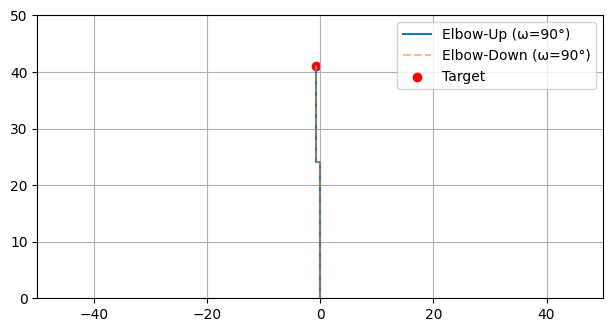

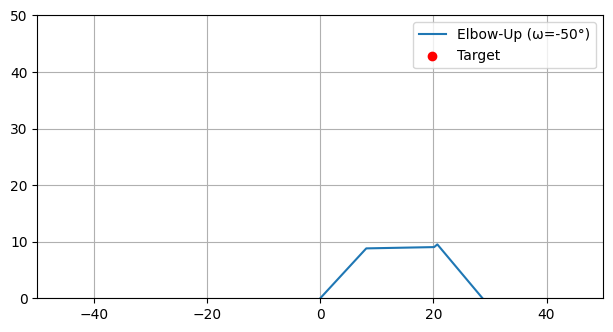

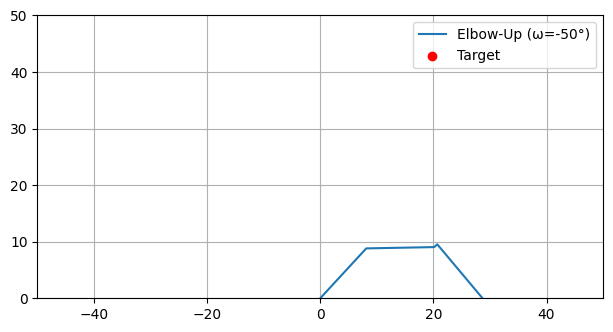

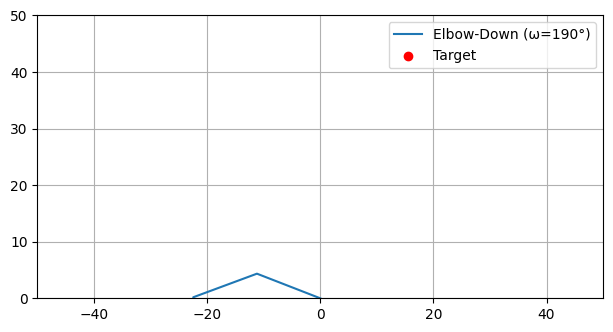

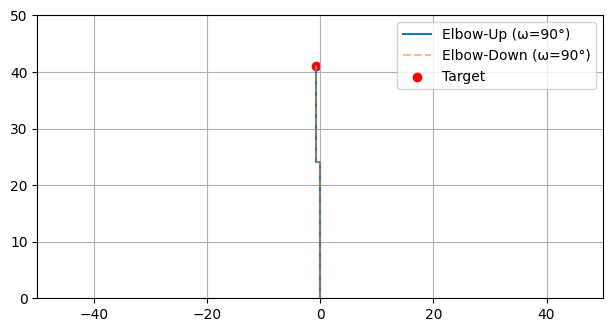

Exception in thread Thread-6 (loop):
Traceback (most recent call last):
  File "c:\Users\Sercan\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\Sercan\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\Sercan\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Sercan\AppData\Local\Temp\ipykernel_27244\1525700245.py", line 145, in loop
  File "C:\Users\Sercan\AppData\Local\Temp\ipykernel_27244\1525700245.py", line 211, in solve_with_auto_omega
  File "c:\Users\Sercan\AppData\Local\Programs\Python\Python311\Lib\tkinter\__init__.py", line 1702, in configure
    return self._configure('configure', cnf, kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sercan\AppData\Local\Programs\Python\Python311\Lib\tkinter\__init__.p

In [ ]:
import mujoco
import mujoco.viewer
import numpy as np
import tkinter as tk
import threading
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from Homography import RealWorldVision
import time
from threading import Lock
mj_lock = Lock()


# --- Sabitler ---
L1, L2, L3 = 12, 12, 17 # 19.45
offset = 0.74

model = mujoco.MjModel.from_xml_path("scene.xml")
data = mujoco.MjData(model)

viewer_running = False
viewer_thread = None
elbow_up = True
current_omega = 90
vision_system = RealWorldVision(model, data)

def ikinematics(xe, ye, ze, omega, is_elbow_up=True):
    w = np.radians(omega)
    J0 = np.degrees(np.arctan2(ze, xe))
    if J0 > 90:
        J0 -= 180
    elif J0 < -90:
        J0 += 180

    r = np.sqrt(xe**2 + ze**2)
    sign = np.sign(xe)
    x3 = sign * r - offset * np.cos(w + np.pi/2) - L3 * np.cos(w)
    y3 = ye - offset * np.sin(w + np.pi/2) - L3 * np.sin(w)
    C = np.sqrt(x3**2 + y3**2)

    if (L1 + L2) >= C - 1e-8:
        alpha = np.degrees(np.arccos(np.clip((L1**2 + L2**2 - C**2) / (2 * L1 * L2), -1.0, 1.0)))
        beta  = np.degrees(np.arccos(np.clip((L1**2 + C**2 - L2**2) / (2 * L1 * C), -1.0, 1.0)))
        
        if is_elbow_up:
            J1 = np.degrees(np.arctan2(y3, x3)) + beta
            J2 = -(180 - alpha)
            J3 = omega - J1 - J2
        else:
            J1 = np.degrees(np.arctan2(y3, x3)) - beta
            J2 = 180 - alpha
            J3 = omega - J1 - J2
        return [np.radians(J0), np.radians(J1), np.radians(J2), np.radians(J3)]
    return None

def within_limits(angles):
    limits = {
        "Yaw": (-np.deg2rad(90), np.deg2rad(90)),
        "Shoulder": (-np.deg2rad(70), np.deg2rad(70)),
        "Elbow": (-np.deg2rad(90), np.deg2rad(90)),
        "Wrist": (-np.deg2rad(90), np.deg2rad(90)),
    }
    names = ["Yaw", "Shoulder", "Elbow", "Wrist"]
    signs = [1, 1, -1, -1]
    for i in range(4):
        a = angles[i] * signs[i]
        low, high = limits[names[i]]
        if not (low - 1e-8 <= a <= high + 1e-8):
            return False
    return True

def find_optimal_omega(xe, ye, ze, is_elbow_up=True):
    """
    Verilen pozisyon için optimal yönelim açısını bulur
    Omega aralığı: -180° ile 360° arası
    
    Bu kol tasarımına göre strateji:
    - Elbow-Up: Genellikle yukarı doğru yönelim tercih edilir (45°-135°)
    - Elbow-Down: Genellikle aşağı/yatay yönelim tercih edilir (-45°-45°)
    """
    
    if is_elbow_up:
        search_range = np.arange(45, 136, 5)
    else:
        search_range = np.arange(-45, 46, 5)
    
    valid_omegas = []
    
    for omega in search_range:
        angles = ikinematics(xe, ye, ze, omega, is_elbow_up)
        if angles:
            converted = [-angles[0], np.deg2rad(90)-angles[1], -angles[2], -angles[3]]
            if within_limits(converted):
                valid_omegas.append(omega)
    
    if valid_omegas:
        if is_elbow_up:
            return min(valid_omegas, key=lambda x: abs(x - 90))
        else:
            return min(valid_omegas, key=lambda x: abs(x))
    
    extended_range = np.arange(-180, 361, 10)
    for omega in extended_range:
        angles = ikinematics(xe, ye, ze, omega, is_elbow_up)
        if angles:
            converted = [-angles[0], np.deg2rad(90)-angles[1], -angles[2], -angles[3]]
            if within_limits(converted):
                return omega
    
    return None

def run_pick_place_loop():
    global auto_mode
    auto_mode = True

    def loop():
        global elbow_up

        while auto_mode:
            coords = vision_system.detect_target(z=0.02)
            if not coords:
                status_label.config(text="✗ Hedef bulunamadı", fg="red")
                time.sleep(1)
                continue

            x, y, z = [c * 100 for c in coords]

            with mj_lock:
                data.ctrl[5] = -np.deg2rad(180)

            # Hedefe git
            elbow_up = True
            if not solve_with_auto_omega(x, y, z, elbow_up):
                elbow_up = False
                if not solve_with_auto_omega(x, y, z, elbow_up):
                    status_label.config(text="✗ Hedefe erişilemiyor", fg="red")
                    time.sleep(1)
                    continue

            with mj_lock:
                data.ctrl[5] = -np.deg2rad(180)
            time.sleep(2.5)

            with mj_lock:
                data.ctrl[5] = -np.deg2rad(75)
            time.sleep(1)

            # Varış noktası
            drop = {'x': -30, 'y': -3.5, 'z': 25}
            elbow_up = True
            if not solve_with_auto_omega(drop['x'], drop['y'], drop['z'], elbow_up):
                elbow_up = False
                solve_with_auto_omega(drop['x'], drop['y'], drop['z'], elbow_up)
            time.sleep(2.5)


            with mj_lock:
                data.ctrl[5] = -np.deg2rad(180)
            time.sleep(1)


            base = (-0.74, 41, 0)
            elbow_up = True
            if not solve_with_auto_omega(*base, elbow_up):
                elbow_up = False
                solve_with_auto_omega(*base, elbow_up)
            time.sleep(2)

    threading.Thread(target=loop, daemon=True).start()


def solve_with_auto_omega(x, y, z, is_elbow_up):
    optimal_omega = find_optimal_omega(x, y, z, is_elbow_up)
    
    if optimal_omega is not None:
        omega_label.config(text=f"Otomatik ω: {optimal_omega:.0f}°")
        
        angles = ikinematics(x, y, z, optimal_omega, is_elbow_up)
        if angles:
            converted = np.array([
                -angles[0], 
                np.deg2rad(90) - angles[1], 
                -angles[2], 
                -angles[3]
            ])
            if within_limits(converted):
                move_to_position(converted, steps=1000, delay=0.01)
                draw_kinematics(canvas_frame, x, y, z)
                status_label.config(text="✓ Çözüm bulundu", fg="green")
                return True
            else:
                status_label.config(text="✗ Limit dışı", fg="red")
        else:
            status_label.config(text="✗ Kinematik çözüm yok", fg="red")
    else:
        omega_label.config(text="Otomatik ω: ---")
        status_label.config(text="✗ Erişilemez nokta", fg="red")
    
    return False



def draw_kinematics(canvas_frame, xe, ye, ze):
    fig, ax = plt.subplots(figsize=(6, 4))
    

    for mode, label in [(True, 'Elbow-Up'), (False, 'Elbow-Down')]:
        optimal_omega = find_optimal_omega(xe, ye, ze, mode)
        if optimal_omega is not None:
            angles = ikinematics(xe, ye, ze, optimal_omega, mode)
            if angles:
                J1 = np.degrees(angles[1])
                J2 = np.degrees(angles[2])
                J3 = np.degrees(angles[3])
                x1 = L1 * np.cos(np.radians(J1))
                y1 = L1 * np.sin(np.radians(J1))
                x2 = x1 + L2 * np.cos(np.radians(J1 + J2))
                y2 = y1 + L2 * np.sin(np.radians(J1 + J2))
                wx = x2 + offset * np.cos(np.radians(J1 + J2 + J3 + 90))
                wy = y2 + offset * np.sin(np.radians(J1 + J2 + J3 + 90))
                x3 = wx + L3 * np.cos(np.radians(J1 + J2 + J3))
                y3 = wy + L3 * np.sin(np.radians(J1 + J2 + J3))
                
                style = '-' if mode == elbow_up else '--'
                alpha = 1.0 if mode == elbow_up else 0.5
                ax.plot([0, x1, x2, wx, x3], [0, y1, y2, wy, y3], style, 
                       label=f'{label} (ω={optimal_omega:.0f}°)', alpha=alpha)
                
                if mode == elbow_up:
                    global current_omega
                    current_omega = optimal_omega

    ax.scatter([xe], [ye], color='red', label='Target')
    ax.set_xlim(-50, 50)
    ax.set_ylim(0, 50)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend()
    
    for w in canvas_frame.winfo_children(): 
        w.destroy()
    canvas = FigureCanvasTkAgg(fig, master=canvas_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

def start_viewer():
    global viewer_running
    viewer_running = True
    with mujoco.viewer.launch_passive(model, data) as viewer:
        while viewer_running and viewer.is_running():
            with mj_lock:
                mujoco.mj_step(model, data)
            viewer.sync()


def toggle_viewer():
    global viewer_thread, viewer_running
    if not viewer_running:
        viewer_thread = threading.Thread(target=start_viewer, daemon=True)
        viewer_thread.start()
        viewer_button.config(text="Viewer'ı Kapat", bg="#f44336")
    else:
        viewer_running = False
        viewer_button.config(text="Viewer'ı Aç", bg="#2196F3")

def toggle_elbow():
    global elbow_up
    elbow_up = not elbow_up
    elbow_button.config(text=f"Mod: {'Elbow-Up' if elbow_up else 'Elbow-Down'}")
    update()

def update():
    try:
        x = float(entry_x.get())
        y = float(entry_y.get())
        z = float(entry_z.get())
        
        # Otomatik omega ile çözüm bul
        solve_with_auto_omega(x, y, z, elbow_up)
        
    except ValueError:
        status_label.config(text="✗ Geçersiz giriş", fg="red")

def calibrate():
    success = vision_system.calibrate()
    print("Kalibrasyon başarılı." if success else "Kalibrasyon başarısız.")

def detect_target():
    if not vision_system.calibrated:
        print("Önce kalibrasyon yapın.")
        return
    coords = vision_system.detect_target(z=0.02)
    if coords:
        coords = [c * 100 for c in coords]
        print(f"Tespit edilen robot koordinatları: X={coords[0]:.1f}cm, Y={coords[1]:.1f}cm, Z={coords[2]:.1f}cm")

        entry_x.delete(0, tk.END)
        entry_x.insert(0, f"{coords[0]:.2f}")
        entry_y.delete(0, tk.END)
        entry_y.insert(0, f"{coords[1]:.2f}")
        entry_z.delete(0, tk.END)
        entry_z.insert(0, f"{coords[2]:.2f}")
        
        update()

        return coords
    else:
        print("Hedef bulunamadı.")


def stop_loop():
    global auto_mode
    auto_mode = False
    status_label.config(text="⏹ Döngü durdu", fg="gray")

def move_to_position(ctrl_target, steps=100, delay=0.01):
    with mj_lock:
        start = np.copy(data.ctrl[:4])
    for i in range(1, steps + 1):
        blend = start + (ctrl_target - start) * (i / steps)
        with mj_lock:
            data.ctrl[:4] = blend
        time.sleep(delay)



# --- GUI ---
root = tk.Tk()
root.title("Otomatik Yönelim Açısı - Inverse Kinematics")

form_frame = tk.Frame(root)
form_frame.pack(pady=5)

tk.Label(form_frame, text="X:").grid(row=0, column=0)
entry_x = tk.Entry(form_frame, width=8)
entry_x.insert(0, "-0.74")
entry_x.grid(row=0, column=1, padx=2)

tk.Label(form_frame, text="Y:").grid(row=0, column=2)
entry_y = tk.Entry(form_frame, width=8)
entry_y.insert(0, "41")
entry_y.grid(row=0, column=3, padx=2)

tk.Label(form_frame, text="Z:").grid(row=0, column=4)
entry_z = tk.Entry(form_frame, width=8)
entry_z.insert(0, "0")
entry_z.grid(row=0, column=5, padx=2)

tk.Button(form_frame, text="Uygula", command=update).grid(row=0, column=6, padx=10)

info_frame = tk.Frame(root)
info_frame.pack(pady=5)

omega_label = tk.Label(info_frame, text="Otomatik ω: ---", font=("Arial", 10, "bold"))
omega_label.pack(side=tk.LEFT, padx=10)

status_label = tk.Label(info_frame, text="", font=("Arial", 10))
status_label.pack(side=tk.LEFT, padx=10)

button_frame = tk.Frame(root)
button_frame.pack(pady=5)

viewer_button = tk.Button(button_frame, text="Viewer'ı Aç", command=toggle_viewer, 
                         bg="#2196F3", fg="white", width=15)
viewer_button.pack(side=tk.LEFT, padx=5)

elbow_button = tk.Button(button_frame, text="Mod: Elbow-Up", command=toggle_elbow, 
                        bg="#FF9800", fg="white", width=15)
elbow_button.pack(side=tk.LEFT, padx=5)

tk.Button(button_frame, text="Kalibre Et", command=calibrate, bg="#791111", fg="white", width=15).pack(side=tk.LEFT, padx=5)
tk.Button(button_frame, text="Hedef Tespit", command=detect_target, bg="#00FF00", fg="white", width=15).pack(side=tk.LEFT, padx=5)

tk.Button(button_frame, text="Başlat Döngü", command=run_pick_place_loop, bg="#008000", fg="white", width=15).pack(side=tk.LEFT, padx=5)
tk.Button(button_frame, text="Durdur Döngü", command=stop_loop, bg="#880000", fg="white", width=15).pack(side=tk.LEFT, padx=5)

# Canvas frame
canvas_frame = tk.Frame(root)
canvas_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)

update()
root.mainloop()